In [2]:
import numpy as np
import shap
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras import layers
from tensorflow import keras
from scipy.ndimage import gaussian_filter
from tqdm import tqdm
from sklearn.decomposition import PCA
from sklearn.metrics import confusion_matrix

## Ładowanie datasetu

In [3]:
data = tf.keras.datasets.mnist.load_data()

In [8]:
train_data, test_data = data
X_train, y_train = train_data
X_test, y_test = test_data

X_train = X_train.reshape(-1, 28, 28, 1).astype(np.float32)
X_test = X_test.reshape(-1, 28, 28, 1).astype(np.float32)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((60000, 28, 28, 1), (10000, 28, 28, 1), (60000,), (10000,))

## Konfiguracja modelu sieci

In [9]:
input_shape = X_train[0].shape
num_classes = 10

model = keras.Sequential(
    [
        keras.Input(shape=input_shape),
        layers.Conv2D(32, kernel_size=(3, 3), activation="relu"),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Conv2D(64, kernel_size=(3, 3), activation="relu"),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Flatten(),
        layers.Dropout(0.5),
        layers.Dense(num_classes, activation="softmax"),
    ]
)

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 26, 26, 32)        320       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 11, 11, 64)        18496     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 5, 5, 64)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 1600)              0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 1600)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 10)               

## Trening modelu

Jeśli korzystacie z własnej architektury sieci przeprowadźcie trening od nowa

In [ ]:
history = model.fit(
    X_train,
    y_train,
    epochs=20,
    batch_size=256,
    validation_data=(X_test, y_test)
)

In [ ]:
x = np.arange(20)
plt.plot(x, history.history['loss'], color='red', label='train loss')
plt.plot(x, history.history['val_loss'], color='blue', label='validation loss')
plt.legend()
plt.show()

plt.plot(x, history.history['accuracy'], color='red', label='train accuracy')
plt.plot(x, history.history['val_accuracy'], color='blue', label='validation accuracy')
plt.legend()
plt.show()

## Ładowanie gotowych wag modelu

Dla leniwych - gotowe wagi

In [10]:
model.load_weights('mnist_weights.h5')

Szybki test czy wszystko działa

In [11]:
test_preds = model.predict(X_test)
test_preds_classes = np.argmax(test_preds, axis=-1)
test_accuracy = np.mean(test_preds_classes == y_test)

print('test accuracy:', round(test_accuracy, 2))

test accuracy: 0.98


# Zadanie 1

Przeprowadź explaining za pomocą DeepExplainera dla przykładowych próbek. Uzupełnij fragmenty kodu zastąpione ???

In [12]:
# Konstrukcja deep explainera
background = X_train[np.random.choice(X_train.shape[0], 100, replace=False)] # ???
explainer = shap.DeepExplainer(model, background) # ???

Using TensorFlow backend.


In [18]:
# Wybór próbek ze zbioru testowego
SAMPLES_COUNT = 5
samples_batch = X_test[:SAMPLES_COUNT] # ???

In [20]:
%%time
# Obliczenie shap values dla batcha wybranych próbek
samples_batch_shap = explainer.shap_values(samples_batch) ## ???

CPU times: user 54.1 s, sys: 44.7 s, total: 1min 38s
Wall time: 26.6 s


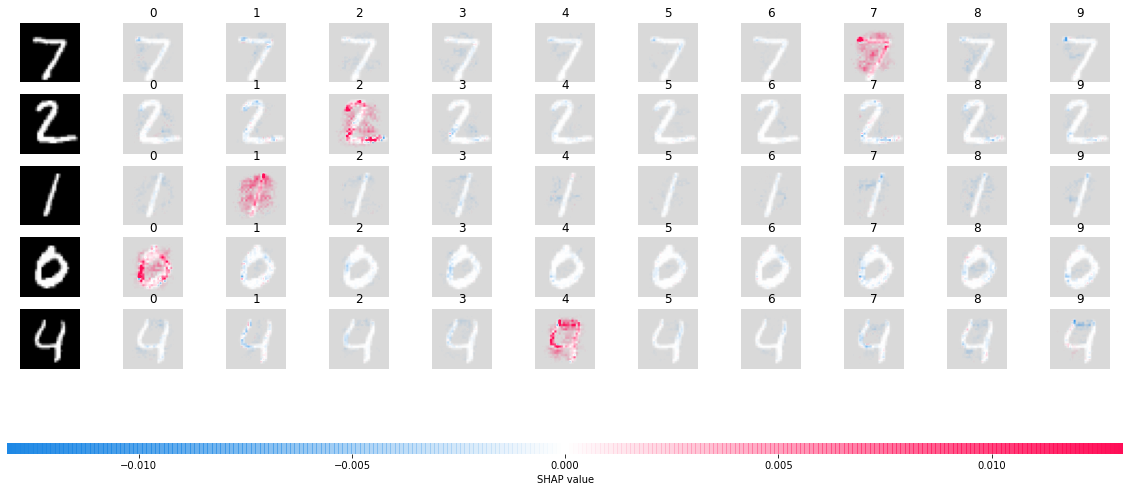

In [22]:
labels = np.array([list(range(10))] * SAMPLES_COUNT)
shap.image_plot(samples_batch_shap, samples_batch / 255., labels=labels)

# Zadanie 2

Wyznacz przynajmniej dwie podobne klasy, które często są ze sobą mylone (wykorzystaj PCA, confusion matrix, lub inną metodę). Następnie znajdź kilka przykładowych próbek należących do z każdej ze znalezionych klas, dla których przy pomocy DeepShap możemy wyraźnie wyznaczyć obszary obrazów pozwalające jednoznacznie wskazać różnice pomiędzy cechami wybranych klas. W badaniu rezultatów może pomóc zaaplikowanie na shap values rozmycia gaussowskiego (warto przetestować wyniki dla różnych wartości parametru sigma).

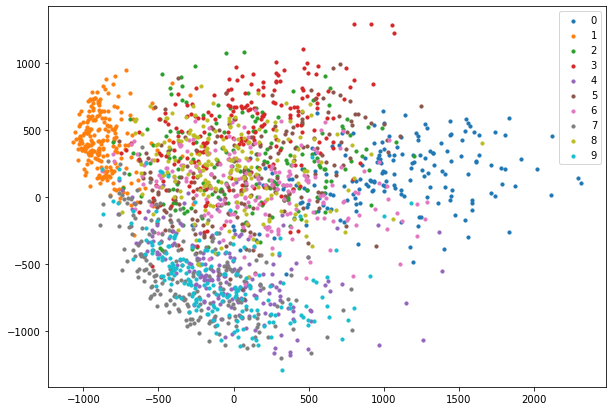

In [27]:
# Wyznaczenie podobnych klas

# ???
batch_size = 2000
batch_indices = np.random.choice(len(X_train), batch_size, replace=False)
X_batch = X_train[batch_indices].reshape((-1, 28 * 28))
batch_labels = y_train[batch_indices]

X_batch_2d = PCA(n_components=2).fit_transform(X_batch)

plt.figure(figsize=(10, 7))
for i in range(10):
    class_indices = batch_labels == i
    plt.scatter(X_batch_2d[class_indices, 0], X_batch_2d[class_indices, 1], s=10, label=i)
plt.legend()
plt.show()

In [28]:
similar_classes_indices = [4, 9] # [???]

In [34]:
# Funkcje pomocnicze
def prep_img(img):
    return np.array([img / 255])


def compare_shap(shap_values, explained_classes, imgs):
    np_shap = np.array(shap_values)
    class_labels = explained_classes
    classes_shap = np_shap[explained_classes]
    for i, img in enumerate(imgs):
        img_shap = list(classes_shap[:, i:i+1])
        shap.image_plot(img_shap, prep_img(img), np.array([class_labels]))
        
        
def blur_shap_values(shap_values, sigma):
    classes_count = len(shap_values)
    samples_count = shap_values[0].shape[0]
    blurred_shap_values = []
    for class_idx in range(classes_count):
        blurred = []
        for sample_idx in range(samples_count):
            blurred.append(gaussian_filter(shap_values[class_idx][sample_idx], sigma=sigma))
        blurred_shap_values.append(blurred)
    return blurred_shap_values

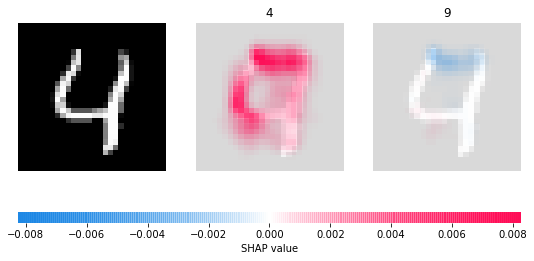

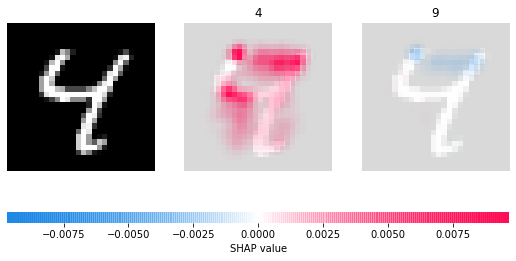

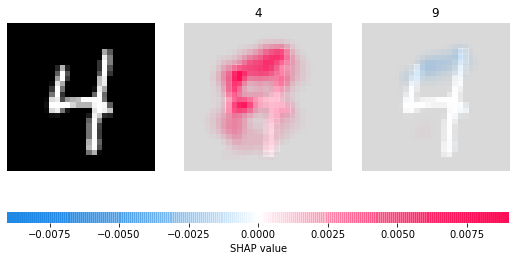

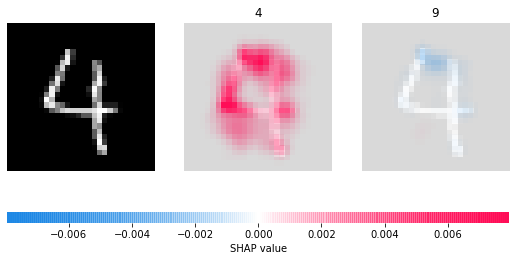

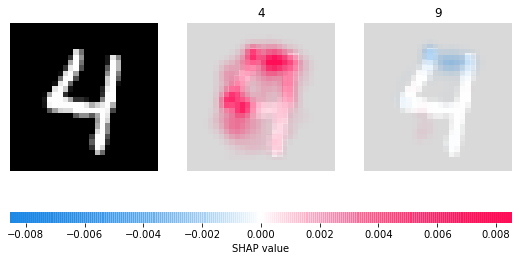

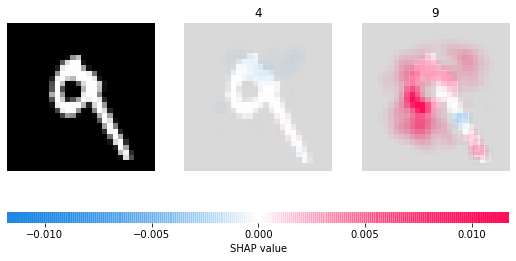

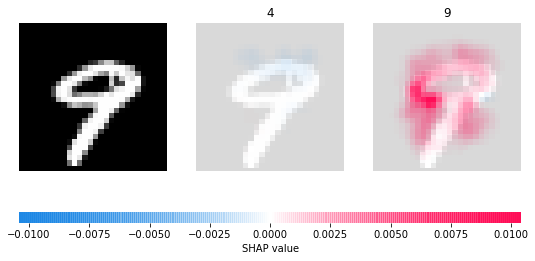

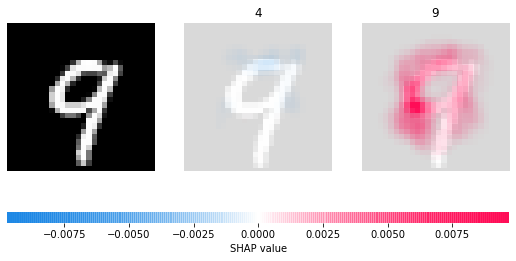

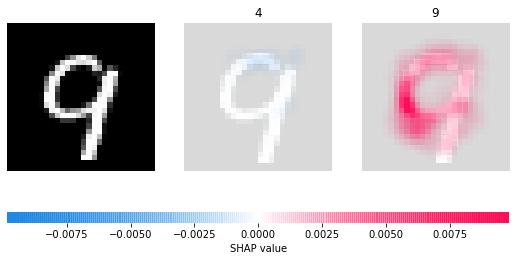

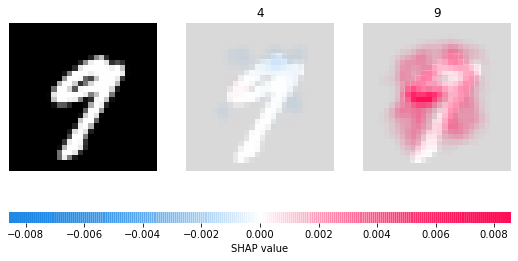

In [36]:
SAMPLES_PER_CLASS = 5

for class_idx in similar_classes_indices:
    class_samples = X_test[y_test == class_idx]
    selected_class_samples = class_samples[:SAMPLES_PER_CLASS] # ???
    
    selected_samples_shap = explainer.shap_values(selected_class_samples) # ???
    blurred_selected_samples_shap = blur_shap_values(selected_samples_shap, 1) # ???
    compare_shap(blurred_selected_samples_shap, similar_classes_indices, selected_class_samples)

Zadania dla studentów:

1) uzupełnianka kodu (wykorzystanie metody) - kod z explainowaniem kilku losowo wybranych probek

2) znajdz przynajmniej jedna pare klas, ktore sa ze soba mylone (albo przy pomocy pca, albo przy pomocy confusion matrix). znajdz kilka przykladow probek z kazdej z tych klas, dla ktorych shap dobrze pokazuje decydujace obszary zdjecia (w badaniu rezultatow moze pomoc zaaplikowanie rozmycia gaussowskiego, sprawdz wyniki dla roznego parametru sigma).

3) przetestuj dzialanie shap dla probek wyznazonych zgodnie z nastepujacymi zasadami:

- probki, ktore zostaly poprawnie sklasyfikowane przez model z najwieksza pewnoscia
- probki, ktore zostaly zupelnie sklasyfikowane z wysoka pewnoscia do zlej klasy
- probki, dla ktorych model waha sie pomiedzy dwoma klasami (predykcje dla obu klas zblizone do 50%)

sprawdz, czy shap pozwala zidentyfikowac problematyczne obszary na zdjeciu.

4) [dodatkowe] Przetestuj działanie explainerów dla różnych backgroundów (np. cały czarny obraz, średnia zbioru itp.). Sprobuj zinterpretowac wybrane probki przy uzyciu kernel explainera. 